In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from datetime import datetime
from random import sample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV, LassoLarsIC, lasso_path
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import ScalarFormatter

warnings.filterwarnings('ignore')
sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=2, color_codes=True,rc={'figure.figsize':(15,10)})

In [3]:
_DATA_DIR = '/classes/20800_winter2023/Data'

In [5]:
def deviance(y, pred, family):
    if family == 'gaussian':
        return np.sum((y - pred)**2)
    if family == 'binomial':
        return -2 * np.sum(y * np.log(pred) + (1-y) * np.log(1-pred))

In [6]:
topic =  pd.read_csv('%s/Monthly_Topic_Attention_Theta.csv'%(_DATA_DIR))


topic['date'] = pd.to_datetime(topic['date'])
topic.set_index('date', inplace=True) 

macro = pd.read_csv('%s/FREDMD_20210218.csv'%(_DATA_DIR)).loc[:,['sasdate','CPIAUCSL']]

macro['sasdate'] = pd.to_datetime(macro['sasdate'])
macro.set_index('sasdate', inplace=True)
macro = macro/macro.shift(1)-1
macro.columns = ['inflation']

df = macro.join(topic).dropna()
df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns.str.replace('&','_')
df.columns = df.columns.str.replace('/','_')
df.columns = df.columns.str.replace('-','_')
df = df.iloc[:,:-1]
df.head()

,inflation,Natural_disasters,Internet,Soft_drinks,Mobile_devices,Profits,M_A,Changes,Police_crime,Research,...,Negotiations,European_politics,Size,NASD,Mexico,Retail,Long_short_term,Wide_range,Lawsuits,UK
sasdate,,,,,,,,,,,,,,,,,,,,,
1984-01-01,0.006903,0.003393,0.001054,0.003522,0.001552,0.009622,0.004586,0.003639,0.004703,0.004628,...,0.005815,0.009105,0.003894,0.003490,0.004669,0.005357,0.004293,0.004955,0.008534,0.004675
1984-02-01,0.004897,0.004640,0.000975,0.004115,0.001611,0.008956,0.005205,0.003648,0.004393,0.004115,...,0.005541,0.007414,0.004008,0.004439,0.003033,0.004055,0.004467,0.004519,0.008337,0.004582
1984-03-01,0.002924,0.005294,0.001018,0.003355,0.001546,0.005529,0.006112,0.003461,0.004456,0.004211,...,0.005206,0.008363,0.003832,0.004134,0.003516,0.004393,0.003914,0.004839,0.009045,0.004731
1984-04-01,0.003887,0.004181,0.000927,0.003663,0.001612,0.010934,0.004572,0.003014,0.005091,0.003741,...,0.005171,0.006124,0.003205,0.003686,0.003467,0.005167,0.004159,0.004557,0.008473,0.003942
1984-05-01,0.001936,0.004179,0.001012,0.003105,0.001612,0.005622,0.004704,0.002953,0.005669,0.003715,...,0.004661,0.007005,0.003816,0.005254,0.003947,0.005518,0.004400,0.005332,0.010317,0.004083


# Full model

In [7]:
# Full model
rest_full = df.columns[1:].tolist()
rest_full = '+'.join(rest_full)

full_model = smf.glm(formula='inflation ~ {}'.format(rest_full), data = df).fit()

print(full_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              inflation   No. Observations:                  402
Model:                            GLM   Df Residuals:                      222
Model Family:                Gaussian   Df Model:                          179
Link Function:               identity   Scale:                      5.0244e-06
Method:                          IRLS   Log-Likelihood:                 2001.4
Date:                Thu, 02 Feb 2023   Deviance:                    0.0011154
Time:                        23:32:08   Pearson chi2:                  0.00112
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [8]:
# number of variables selected
N_full = len(df.columns[1:])
N_full

179

In [9]:
# Estimation and Goodness of Fit

full_R2 = 1-full_model.deviance/full_model.null_deviance
full_AIC = full_model.aic
full_BIC = full_model.bic

print("full model R2:",round(full_R2,2))
print("full model AIC:", round(full_AIC,2))
print("full model BIC:", round(full_BIC,2))

full model R2: 0.58
full model AIC: -3642.76
full model BIC: -1331.21


# Screening

In [10]:
n = df.shape[0]

# standardize
scaler = StandardScaler().fit(df) 
df_scaled = scaler.transform(df)
df_scaled = pd.DataFrame(df_scaled)

In [11]:
# compute correlation
cor = df_scaled.corr()[0][1:]

In [12]:
# Reducecd dimension
d = (cor.abs()>0.1).sum()

In [13]:
# select variables with high correlation
reduced = (np.argsort(abs(cor))+1)[df.shape[1]-d-1:]
reduced = list(reduced)
var_reduced = list(df.iloc[:,reduced].columns)

In [14]:
var_reduced

['France_Italy',
 'Options_VIX',
 'Courts',
 'Nuclear_North_Korea',
 'Systems',
 'Earnings',
 'UK',
 'Financial_reports',
 'European_politics',
 'Foods_consumer_goods',
 'Elections',
 'Product_prices',
 'Problems',
 'Insurance',
 'Disease',
 'Unions',
 'SEC',
 'Real_estate',
 'Rail_trucking_shipping',
 'Humor_language',
 'Earnings_losses',
 'International_exchanges',
 'C_suite',
 'Machinery',
 'Profits',
 'Private_public_sector',
 'News_conference',
 'Futures_indices',
 'Internet',
 'Political_contributions',
 'Research',
 'Southeast_Asia',
 'Latin_America',
 'Nonperforming_loans',
 'Trade_agreements',
 'Cultural_life',
 'Retail',
 'Job_cuts',
 'Steel',
 'Utilities',
 'Airlines',
 'Scenario_analysis',
 'Reagan',
 'Agriculture',
 'China',
 'Canada_South_Africa',
 'Short_sales',
 'Bush_Obama_Trump',
 'Rental_properties',
 'Committees',
 'Acquired_investment_banks',
 'Immigration',
 'Japan',
 'Activists',
 'Long_short_term',
 'Mobile_devices',
 'Mid_size_cities',
 'Savings___loans',
 'NY_

In [15]:
len(var_reduced) 

101

In [16]:
cor = pd.DataFrame(np.transpose(np.array([df.columns[1:],cor])))
cor.columns = ['variable','correlation']
cor = cor.sort_values(['correlation'], ascending=False).reset_index(drop=True)
cor

,variable,correlation
0,Macroeconomic_data,0.244953
1,Aerospace_defense,0.244819
2,Commodities,0.238175
3,Trading_activity,0.227117
4,Treasury_bonds,0.225543
...,...,...
174,Corrections_amplifications,-0.230138
175,Terrorism,-0.237932
176,European_sovereign_debt,-0.25834
177,Financial_crisis,-0.263844


<AxesSubplot:xlabel='correlation', ylabel='Count'>

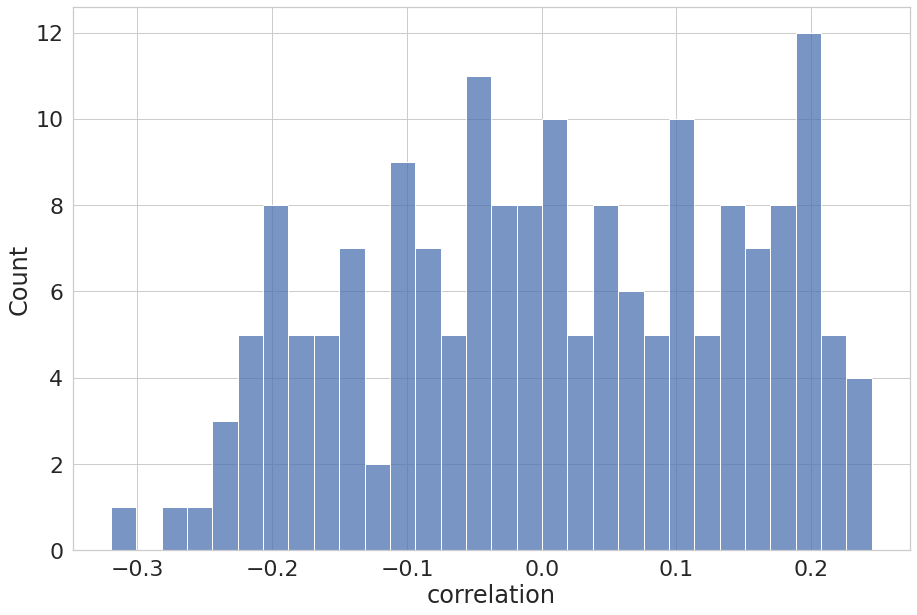

In [17]:
sns.histplot(cor.correlation,bins=30)
#plt.savefig('correlation_histogram.pdf')

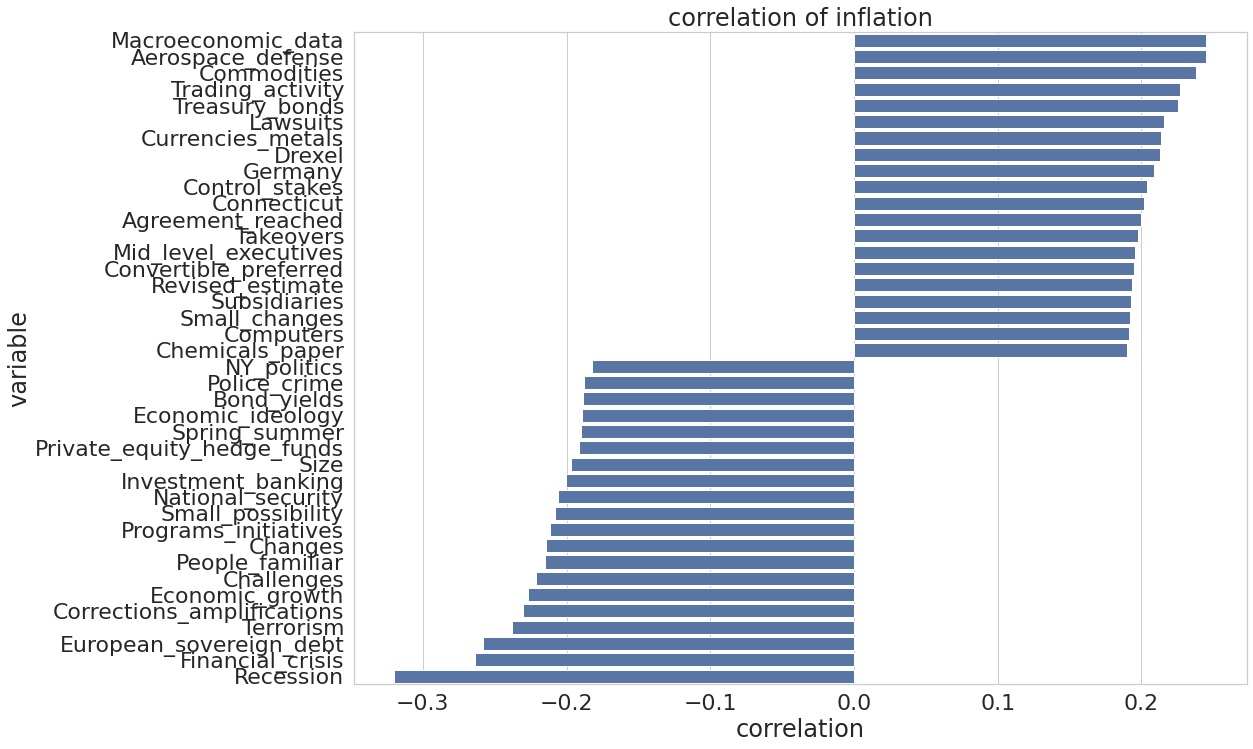

In [18]:
cor = cor.sort_values(['correlation'], ascending=False).reset_index(drop=True)
corr = cor.iloc[np.r_[0:20, -20:0]] # show first and last rows
plt.figure(figsize = (16,12))
sns.barplot(
    x="correlation", 
    color = 'b',
    y="variable", 
    data=corr, 
    estimator=sum
);
plt.title('correlation of inflation')
plt.savefig('correlation_bar.pdf')

In [19]:
# number of variables selected
N_SIS = len(var_reduced)
N_SIS

101

In [20]:
rest_reduced  = '+'.join(var_reduced)

reduced_model = smf.glm(formula='inflation ~ {}'.format(rest_reduced), data=df).fit()

print(reduced_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              inflation   No. Observations:                  402
Model:                            GLM   Df Residuals:                      300
Model Family:                Gaussian   Df Model:                          101
Link Function:               identity   Scale:                      5.3558e-06
Method:                          IRLS   Log-Likelihood:                 1928.0
Date:                Thu, 02 Feb 2023   Deviance:                    0.0016067
Time:                        23:32:22   Pearson chi2:                  0.00161
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [19]:
# Estimation and Goodness of Fit

SIS_R2 = 1-reduced_model.deviance/reduced_model.null_deviance
SIS_AIC = reduced_model.aic
SIS_BIC = reduced_model.bic

print("SIS model R2:",round(SIS_R2,2))
print("SIS model AIC:", round(SIS_AIC,2))
print("SIS model BIC:", round(SIS_BIC,2))

SIS model R2: 0.39
SIS model AIC: -3652.03
SIS model BIC: -1798.93


In [20]:
def SIS(data,thrd):
    """
    Linear model designed by screening.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    Returns:
    --------
    model: an "optimal" fitted linear model,
           selected by sure independence screening 
    """
    
    n = data.shape[0]


    # standardize
    scaler = StandardScaler().fit(data) 
    data_scaled = scaler.transform(data)
    data_scaled = pd.DataFrame(data_scaled)
    
    
    cor = data_scaled.corr()[0][1:]
    d = (cor.abs()>thrd).sum()


    reduced = (np.argsort(abs(cor))+1)[data.shape[1]-d-1:]
    reduced = list(reduced)
    var_reduced = list(data.iloc[:,reduced].columns)
        
    rest_reduced  = '+'.join(var_reduced)
    reduced_model = smf.glm(formula='inflation ~ {}'.format(rest_reduced), data=data).fit()
    
    
    return reduced_model

# Out-of-sample R2


In [21]:
## Sample of half random indices
N = len(df)
leaveout = range(4*N//5,N)

In [22]:
yout = df[['inflation']].iloc[leaveout]
yin  = df.drop(df.index[leaveout])[['inflation']]

In [23]:
# oos without screening
variable  = '+'.join(df.iloc[:,1:].columns)
y_pred = smf.glm(formula='inflation ~ {}'.format(variable), data=df.drop(df.index[leaveout])).fit().predict(df.iloc[leaveout])
dev0 = deviance(yout.inflation,yin.inflation.mean(), family = 'gaussian')
dev = deviance(yout.inflation, y_pred, family = 'gaussian')

OOS_R2 = 1-dev/dev0

In [24]:
# oos with screening 
y_pred_sis = SIS(df.drop(df.index[leaveout]),0.1).predict(df.iloc[leaveout])
dev0 = deviance(yout.inflation,yin.inflation.mean(), family = 'gaussian')
dev = deviance(yout.inflation, y_pred_sis, family = 'gaussian')

OOS_SIS_R2 = 1-dev/dev0

# Forward stepwise feature selection algorithm

In [25]:
def forward_selected(data, response, Kmax):
    """
    Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response
    response: string, name of response column in data
    Kmax : max number of selected variables

    Returns:
    --------
    model: an "optimal" fitted linear model,
           selected by forward stepwise algorithm, 
           evaluated by AIC
    """
    K = 0
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = np.inf, np.inf
    while remaining and current_score == best_new_score and K <= Kmax:
        scores_with_candidates = []
        
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.glm(formula, data).fit().aic
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort(reverse = True)
        best_new_score, best_candidate = scores_with_candidates.pop()

        
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            K = len(selected)
            #print('Add  {:30} with AIC {:.6}'.format(best_candidate, best_new_score))

            
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    print('Algorithm Finished.')
    model = smf.glm(formula, data).fit()
    return model

In [26]:
import time

start_time = time.time()

forward = forward_selected(df, response='inflation', Kmax = 100)

time = time.time() - start_time
print(time)

Algorithm Finished.
91.57275652885437


In [27]:
print(forward.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              inflation   No. Observations:                  402
Model:                            GLM   Df Residuals:                      372
Model Family:                Gaussian   Df Model:                           29
Link Function:               identity   Scale:                      4.3587e-06
Method:                          IRLS   Log-Likelihood:                 1926.2
Date:                Wed, 18 Jan 2023   Deviance:                    0.0016214
Time:                        15:03:50   Pearson chi2:                  0.00162
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [28]:
# number of variables selected
N_forward = len(forward.params)-1
N_forward

29

In [29]:
# Estimation and Goodness of Fit

forward_R2 = 1-forward.deviance/forward.null_deviance
forward_AIC = forward.aic
forward_BIC = forward.bic

print("stepwise forward model R2:",round(forward_R2,2))
print("stepwise forward model AIC:", round(forward_AIC,2))
print("stepwise forward model BIC:", round(forward_BIC,2))

stepwise forward model R2: 0.38
stepwise forward model AIC: -3792.37
stepwise forward model BIC: -2230.68


In [30]:
# oos with screening 
y_pred_fwd = forward_selected(df.drop(df.index[leaveout]), response='inflation', Kmax = 100).predict(df.iloc[leaveout])
dev0 = deviance(yout.inflation,yin.inflation.mean(), family = 'gaussian')
dev = deviance(yout.inflation, y_pred_fwd, family = 'gaussian')
OOS_forward_R2 = 1-dev/dev0

Algorithm Finished.


In [31]:
Nvars = [N_full,N_SIS,N_forward]
R2 = [full_R2,SIS_R2,forward_R2]
OOS_R2 = [OOS_R2,OOS_SIS_R2,OOS_forward_R2]
AIC = [full_AIC,SIS_AIC,forward_AIC]
BIC = [full_BIC,SIS_BIC,forward_BIC]

df1 = pd.DataFrame(data = [Nvars, R2, OOS_R2, AIC,BIC], columns= ["full", "screening", "forward"]).round(2)
df1.index = ['#variables', 'R2','OOS R2','AIC', 'BIC']
df1

,full,screening,forward
#variables,179.00,101.00,29.00
R2,0.58,0.39,0.38
OOS R2,-2.86,-1.35,-1.43
AIC,-3642.76,-3652.03,-3792.37
BIC,-1331.21,-1798.93,-2230.68


# Model selection based on Lasso

In [21]:
# standardize
X = df.iloc[:,1:]
y = df[['inflation']]
Xscaler = StandardScaler().fit(X) 
yscaler = StandardScaler().fit(y) 


X_scaled = Xscaler.transform(X)
y_scaled = yscaler.transform(y)

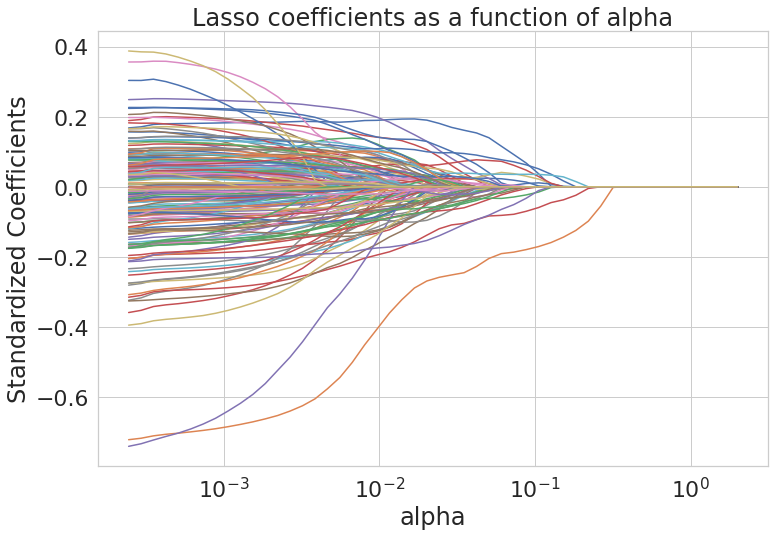

In [22]:
# lasso path
alphas = 2**(np.linspace(-12, 1, 50))
lasso = Lasso(max_iter=10000)
coefs = []

alphas, coefs, _ = lasso_path(X_scaled, y_scaled, alphas=alphas)
coefs = coefs[0].T

plt.figure(figsize = (12,8))
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');
#plt.savefig('lasso_path.pdf')

## Lasso model selection based on AIC

In [23]:
model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X_scaled, y_scaled)

# Show best value of penalization chosen by AIC
alpha_aic_ = model_aic.alpha_
print(alpha_aic_)

# refit
model_aic1 = lasso.set_params(alpha=alpha_aic_).fit(X_scaled, y_scaled)

0.004251441792976971


In [24]:
# number of variables selected

N_LassoAIC = (model_aic1.coef_!=0).sum()
N_LassoAIC

149

In [25]:
# selected variables

list(X.columns[model_aic1.coef_!=0])

['Natural_disasters',
 'Internet',
 'Soft_drinks',
 'Mobile_devices',
 'Profits',
 'M_A',
 'Police_crime',
 'Research',
 'Executive_pay',
 'Mid_size_cities',
 'Scenario_analysis',
 'Economic_ideology',
 'Middle_east',
 'Savings___loans',
 'IPOs',
 'Restraint',
 'Electronics',
 'Record_high',
 'Connecticut',
 'Steel',
 'Bond_yields',
 'Small_business',
 'Cable',
 'Fast_food',
 'Disease',
 'Activists',
 'Competition',
 'Short_sales',
 'Nonperforming_loans',
 'Key_role',
 'News_conference',
 'US_defense',
 'Political_contributions',
 'Economic_growth',
 'Justice_Department',
 'Credit_ratings',
 'Broadcasting',
 'Problems',
 'Announce_plan',
 'Federal_Reserve',
 'Job_cuts',
 'Chemicals_paper',
 'Small_caps',
 'Control_stakes',
 'Mutual_funds',
 'Venture_capital',
 'European_sovereign_debt',
 'Mining',
 'Company_spokesperson',
 'Private_public_sector',
 'Pharma',
 'Schools',
 'Russia',
 'Health_insurance',
 'Drexel',
 'Trade_agreements',
 'Challenges',
 'People_familiar',
 'Sales_call',
 'P

In [26]:
# Estimation and Goodness of Fit

LassoAIC_pred = model_aic1.predict(X_scaled).reshape(-1, 1)
LassoAIC_pred = yscaler.inverse_transform(LassoAIC_pred).reshape(-1)

dev0 = deviance(y.inflation,y.inflation.mean(), family = 'gaussian')
dev = deviance(y.inflation, LassoAIC_pred, family = 'gaussian')
LassoAIC_R2 = 1-dev/dev0

print("LassoAIC R2:",round(LassoAIC_R2,2))

LassoAIC R2: 0.54


## Lasso model selection based on BIC

In [27]:
model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(X_scaled, y_scaled)

# Show best value of penalization chosen by BIC
alpha_bic_ = model_bic.alpha_
print(alpha_bic_)

# refit
model_bic1 = lasso.set_params(alpha=alpha_bic_).fit(X_scaled, y_scaled)

0.008782863914970023


In [28]:
# number of variables selected

N_LassoBIC = (model_bic1.coef_!=0).sum()
N_LassoBIC

114

In [29]:
# selected variables

list(X.columns[model_bic1.coef_!=0])

['Natural_disasters',
 'Internet',
 'Soft_drinks',
 'Mobile_devices',
 'M_A',
 'Police_crime',
 'Research',
 'Executive_pay',
 'Scenario_analysis',
 'Economic_ideology',
 'Middle_east',
 'IPOs',
 'Restraint',
 'Electronics',
 'Record_high',
 'Connecticut',
 'Steel',
 'Bond_yields',
 'Cable',
 'Fast_food',
 'Disease',
 'Activists',
 'Competition',
 'Nonperforming_loans',
 'Key_role',
 'News_conference',
 'US_defense',
 'Political_contributions',
 'Justice_Department',
 'Credit_ratings',
 'Broadcasting',
 'Problems',
 'Federal_Reserve',
 'Job_cuts',
 'Environment_',
 'Control_stakes',
 'Mutual_funds',
 'Venture_capital',
 'European_sovereign_debt',
 'Mining',
 'Company_spokesperson',
 'Private_public_sector',
 'Russia',
 'Health_insurance',
 'Trade_agreements',
 'Challenges',
 'Sales_call',
 'Publishing',
 'Aerospace_defense',
 'Recession',
 'Cultural_life',
 'SEC',
 'Computers',
 'Marketing',
 'Nuclear_North_Korea',
 'NY_politics',
 'Tobacco',
 'Product_prices',
 'Movie_industry',
 'Aut

In [30]:
# Estimation and Goodness of Fit

LassoBIC_pred = model_bic1.predict(X_scaled).reshape(-1, 1)
LassoBIC_pred = yscaler.inverse_transform(LassoBIC_pred).reshape(-1)

dev0 = deviance(y.inflation,y.inflation.mean(), family = 'gaussian')
dev = deviance(y.inflation, LassoBIC_pred, family = 'gaussian')
LassoBIC_R2 = 1-dev/dev0

print("LassoBIC R2:",round(LassoBIC_R2,2))

LassoBIC R2: 0.49


Text(0.5, 1.0, 'Information-criterion for model selection')

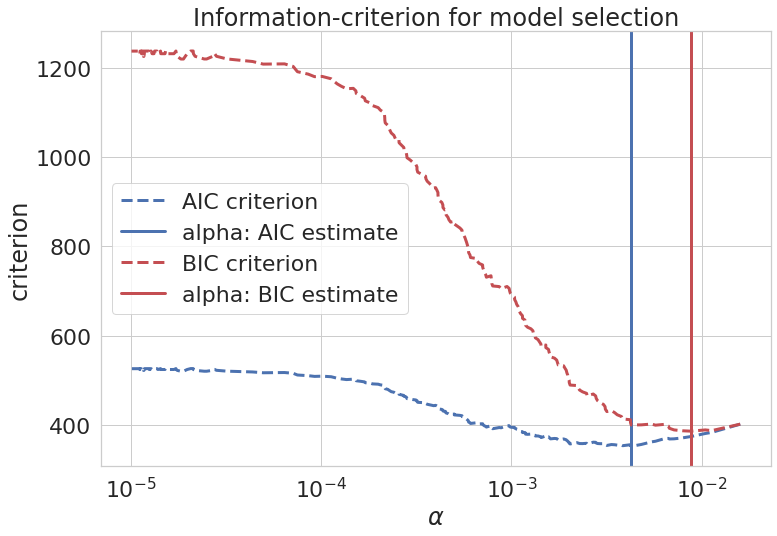

In [31]:
EPSILON = 1e-5

from matplotlib.ticker import ScalarFormatter
def plot_ic_criterion(model, name, color):
    criterion_ = model.criterion_
    plt.semilogx(model.alphas_ + EPSILON, criterion_, '--', color=color,
                 linewidth=3, label='%s criterion' % name)
    plt.axvline(model.alpha_ + EPSILON, color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel(r'$\alpha$')
    plt.ylabel('criterion')

plt.figure(figsize = (12,8))
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()

plt.title('Information-criterion for model selection')

#plt.savefig('lasso_aicbic.pdf')

## Lasso model selection based on deviance (with cross-validation)

In [37]:
def lasso_alphas(X_train, y_train, X_valid, y_valid, alphas):
    """ Get series of dev0 and dev for given training and validation data and alphas
    X_train: np.array of training covariates
    y_train: np.array of training labels
    X_valid: np.array of validation covariates
    y_valid: np.array of validation labels
    alphas: array of penalty strength
    """
    
    # define scalar
    Xscaler = StandardScaler().fit(X_train) 
    yscaler = StandardScaler().fit(y_train) 
    
    # define scaled dataframe
    X_train_scaled = Xscaler.transform(X_train)
    y_train_scaled = yscaler.transform(y_train)
    X_valid_scaled = Xscaler.transform(X_valid)
    
    # perform lasso with alphas
    dev0_ser, dev_ser = pd.Series(index=alphas), pd.Series(index=alphas)
    alphas, coefs, dual_gaps = lasso_path(X_train_scaled, y_train_scaled, alphas=alphas)
    coefs = coefs[0]

    for idx, alpha in enumerate(alphas):
        model = Lasso(alpha=alpha)
        coef = coefs[:, idx]
        intercept = (X_train_scaled @ coef - y_train_scaled).reshape(-1).mean()
        model.coef_ = coef
        model.intercept_ = intercept
        
        # make predictions with the rebuilt lasso model 
        y_pred_scaled = model.predict(X_valid_scaled).reshape(-1, 1)
        y_pred = yscaler.inverse_transform(y_pred_scaled).reshape(-1)
        
        # calculate deviance
        dev0 = deviance(y_valid, y_train.mean(), family = 'gaussian')
        dev = deviance(y_valid, y_pred, family = 'gaussian')
        
        dev0_ser.loc[alpha] = dev0
        dev_ser.loc[alpha] = dev
    
    return dev0_ser, dev_ser

# K-fold Validation

In [24]:
# setup 
n = df.shape[0]  # the number of observations
K = 10  # the number of folds
tmp = np.repeat(np.array(range(1,K+1)), np.ceil(n/K))[0:n]  # create a vector of fold memberships

In [25]:
# create foldid
foldid = pd.DataFrame(tmp)
foldid.columns= ['foldid']

In [26]:
# cross-validation
alphas = 2**(np.linspace(-12,1,50))
CV_table = pd.DataFrame(index = alphas, columns = range(K))
CV_table.index.name = "alpha"

for k in range(K):
    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Working on fold {k+1} ...")
    train_idx = foldid[foldid.foldid != (k+1)].index.tolist()
    valid_idx = foldid[foldid.foldid == (k+1)].index.tolist()
    train = df.iloc[train_idx,:]
    valid = df.iloc[valid_idx,:]
    X_train = train.drop(columns = 'inflation')
    y_train = train.inflation.values.reshape(-1, 1)
    X_valid = valid.drop(columns = 'inflation')
    y_valid = valid.inflation.values.reshape(-1, 1)
    
    dev0_ser, dev_ser = lasso_alphas(X_train, y_train, X_valid, y_valid, alphas)
    CV_table.loc[:,k] = dev_ser
    CV_table_mean = CV_table/(n/K) # Table of OOS MSE

2023-02-02 22:49:22 Working on fold 1 ...
2023-02-02 22:49:23 Working on fold 2 ...
2023-02-02 22:49:24 Working on fold 3 ...
2023-02-02 22:49:25 Working on fold 4 ...
2023-02-02 22:49:27 Working on fold 5 ...
2023-02-02 22:49:28 Working on fold 6 ...
2023-02-02 22:49:29 Working on fold 7 ...
2023-02-02 22:49:30 Working on fold 8 ...
2023-02-02 22:49:31 Working on fold 9 ...
2023-02-02 22:49:32 Working on fold 10 ...


In [27]:
# find alpha best alpha 
ind_min = np.argmin(CV_table_mean.values.mean(axis = 1))
alpha_best = alphas[ind_min]
alpha_best

0.12678079837091596

In [28]:
# refit model 
model_cv = Lasso(alpha=alpha_best)
model_cv.fit(X_scaled, y_scaled)

Lasso(alpha=0.12678079837091596)

In [29]:
# estimation and goodness of Fit
LassoCV_pred = model_cv.predict(X_scaled).reshape(-1, 1)
LassoCV_pred = yscaler.inverse_transform(LassoCV_pred).reshape(-1)

dev0 = deviance(y.inflation,y.inflation.mean(), family = 'gaussian')
dev = deviance(y.inflation, LassoCV_pred, family = 'gaussian')
LassoCV_R2 = 1-dev/dev0

print("LassoCV R2:",round(LassoCV_R2,2))

LassoCV R2: 0.12


# 1se Rule

In [30]:
# cross-validation
alphas = 2**(np.linspace(-12,1,50))
CV_table = pd.DataFrame(index = alphas, columns = range(K))
CV_table.index.name = "alpha"
for k in range(K):
    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Working on fold {k+1} ...")
    train_idx = foldid[foldid.foldid != (k+1)].index.tolist()
    valid_idx = foldid[foldid.foldid == (k+1)].index.tolist()
    train = df.iloc[train_idx,:]
    valid = df.iloc[valid_idx,:]
    X_train = train.drop(columns = 'inflation')
    y_train = train.inflation.values.reshape(-1, 1)
    X_valid = valid.drop(columns = 'inflation')
    y_valid = valid.inflation.values.reshape(-1, 1)
    
    dev0_ser, dev_ser = lasso_alphas(X_train, y_train, X_valid, y_valid, alphas)
    CV_table.loc[:,k] = dev_ser 
CV_table_mean = CV_table/(n/K) # Table of OOS MSE

2023-02-02 22:49:51 Working on fold 1 ...
2023-02-02 22:49:52 Working on fold 2 ...
2023-02-02 22:49:53 Working on fold 3 ...
2023-02-02 22:49:54 Working on fold 4 ...
2023-02-02 22:49:55 Working on fold 5 ...
2023-02-02 22:49:56 Working on fold 6 ...
2023-02-02 22:49:57 Working on fold 7 ...
2023-02-02 22:49:58 Working on fold 8 ...
2023-02-02 22:49:59 Working on fold 9 ...
2023-02-02 22:50:00 Working on fold 10 ...


In [32]:
# find alpha best alpha 
ind_min = np.argmin(CV_table_mean.values.mean(axis = 1))
alpha_best = alphas[ind_min]
alpha_best

0.12678079837091596

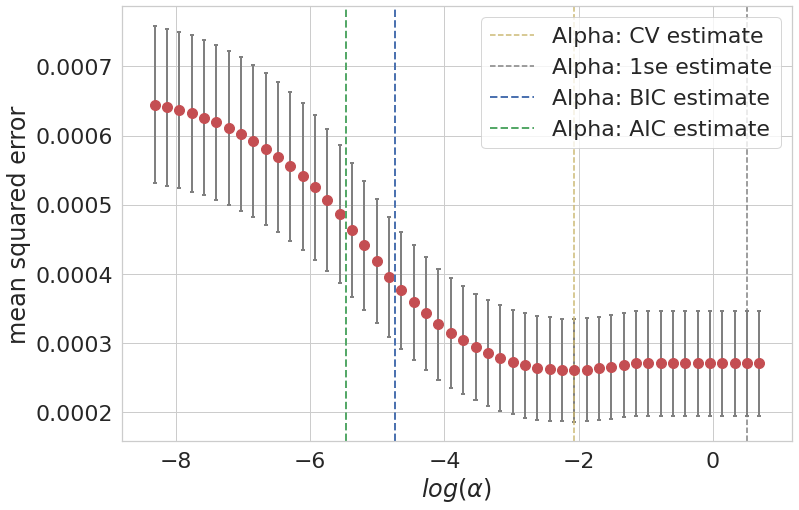

In [34]:
ind_min = np.argmin(CV_table_mean.values.mean(axis = 1))
lambda_mse = CV_table_mean.values[ind_min].mean()
mse_1se = np.std(CV_table_mean.values[ind_min])/np.sqrt(K)


for j in range(ind_min,len(alphas)-1):
    if np.mean(CV_table_mean.values[j+1]) > lambda_mse+mse_1se:
        break
        
alpha_1se = np.log(alphas[j])
plt.figure(figsize = (12,8))

# plt.plot(alphas,CV_table.mean(axis = 1),'k',
#          label='Average across the folds', linewidth=2)

plt.axvline(np.log(alpha_best), linestyle='--', color='y',
            label='Alpha: CV estimate')

plt.axvline(alpha_1se, linestyle='--', color='grey',
            label='Alpha: 1se estimate')

for i in range(len(alphas)):
    lambda_mse = CV_table_mean.values[i].mean()
    mse_1se = np.std(CV_table_mean.values[i])/np.sqrt(K)
    plt.plot(np.log(alphas[i]),lambda_mse,marker="o", markersize=10, markeredgecolor="r", markerfacecolor="r")
    plt.hlines(lambda_mse + mse_1se, xmin=np.log(alphas[i])-0.03, xmax = np.log(alphas[i])+0.03, linewidth=2, color='grey')
    plt.hlines(lambda_mse - mse_1se, xmin=np.log(alphas[i])-0.03, xmax =np.log(alphas[i])+0.03, linewidth=2, color='grey')
    plt.vlines(np.log(alphas[i]), lambda_mse - mse_1se,lambda_mse + mse_1se, linewidth=2, color='grey')

plt.axvline(np.log(model_bic.alpha_), linestyle='--', color='b',
            linewidth = 2, label='Alpha: BIC estimate')

plt.axvline(np.log(model_aic.alpha_), linestyle='--', color='g',
            linewidth = 2, label='Alpha: AIC estimate')

plt.legend()

plt.xlabel(r'$log(\alpha)$')
plt.ylabel('mean squared error')
plt.savefig('band_1se.pdf')
plt.show()

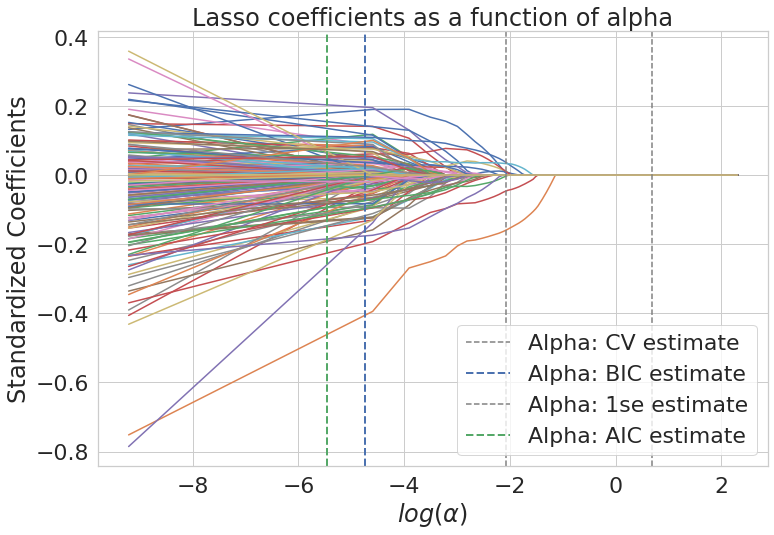

In [31]:
# lasso path
alphas = np.linspace(1e-4,1e+1,1000)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_scaled, y_scaled)
    coefs.append(lasso.coef_)

plt.figure(figsize = (12,8))
ax = plt.gca()

ax.plot(np.log(alphas), coefs)
#ax.set_xscale('log')
plt.axis('tight')
plt.xlabel(r'$log(\alpha)$')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

plt.axvline(np.log(alpha_best), linestyle='--', color='grey',
            label='Alpha: CV estimate')

plt.axvline(np.log(model_bic.alpha_), linestyle='--', color='b',
            linewidth = 2, label='Alpha: BIC estimate')

plt.axvline(alpha_1se, linestyle='--', color='grey',
            label='Alpha: 1se estimate')

plt.axvline(np.log(model_aic.alpha_), linestyle='--', color='g',
            linewidth = 2, label='Alpha: AIC estimate')

plt.legend()
plt.savefig('lasso_path_selection.pdf')
plt.show()

# All methods

In [32]:
def cv(df,K,alphas):
    # setup
    n = df.shape[0]  # the number of observations
    K = 10  # the number of folds
    tmp = np.repeat(np.array(range(1,K+1)), np.ceil(n/K))[0:n]  # create a vector of fold memberships
    # create foldid
    foldid = pd.DataFrame(tmp)
    foldid.columns= ['foldid']
    # cross-validation
    CV_table = pd.DataFrame(index = alphas, columns = range(K))
    CV_table.index.name = "alpha"
    for k in range(K):
        print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} Working on fold {k+1} ...")
        train_idx = foldid[foldid.foldid != (k+1)].index.tolist()
        valid_idx = foldid[foldid.foldid == (k+1)].index.tolist()
        train = df.iloc[train_idx,:]
        valid = df.iloc[valid_idx,:]
        X_train = train.drop(columns = 'inflation')
        y_train = train.inflation.values.reshape(-1, 1)
        X_valid = valid.drop(columns = 'inflation')
        y_valid = valid.inflation.values.reshape(-1, 1)

        dev0_ser, dev_ser = lasso_alphas(X_train, y_train, X_valid, y_valid, alphas)
        CV_table.loc[:,k] = dev_ser
    return CV_table

In [33]:
def plot_ic_criterion(model, name, color):
    criterion_ = model.criterion_
    EPSILON = 1e-5
    plt.semilogx(model.alphas_ + EPSILON, criterion_, '--', color=color,
                 linewidth=3, label='%s criterion' % name)
    plt.axvline(model.alpha_ + EPSILON, color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel(r'$\alpha$')
    plt.ylabel('criterion')

In [34]:
n

402

In [35]:
def ParSelect(df,K,alphas):
    """ Model selection with different methods
    df: data frame of or covariates
    K: Number of folds in CV
    alphas: array of penalty strength
    """
    
    # standardize
    X = df.iloc[:,1:]
    y = df[['inflation']]
    Xscaler = StandardScaler().fit(X) 
    yscaler = StandardScaler().fit(y) 

    X_scaled = Xscaler.transform(X)
    y_scaled = yscaler.transform(y)
    
    lasso = Lasso(max_iter=10000)
    # AIC

    model_aic = LassoLarsIC(criterion='aic').fit(X_scaled, y_scaled)

    # BIC

    model_bic = LassoLarsIC(criterion='bic').fit(X_scaled, y_scaled)

    plt.figure(figsize = (12,8))
    plot_ic_criterion(model_aic, 'AIC', 'b')
    plot_ic_criterion(model_bic, 'BIC', 'r')
    plt.legend()

    plt.title('Information-criterion for model selection')
    
    # find alpha best alpha 
    CV_table = cv(df,K,alphas)
    CV_table_mean = CV_table/(n/K)
    CV_mean = CV_table.mean(axis=1)
    ind_min = np.argmin(CV_table.values.mean(axis = 1))
    alpha_best = alphas[ind_min]
    lambda_mse = CV_table.values[ind_min].mean()
    mse_1se = np.std(CV_table.values[ind_min])/np.sqrt(K)


    for j in range(ind_min,len(alphas)-1):
        if np.mean(CV_table.values[j+1]) > lambda_mse+mse_1se:
            break

    alpha_1se = np.log(alphas[j])
    plt.figure(figsize = (12,8))

    # plt.plot(alphas,CV_table.mean(axis = 1),'k',
    #          label='Average across the folds', linewidth=2)
    plt.axvline(np.log(alpha_best), linestyle='--', color='y',
                label='Alpha: CV estimate')

    plt.axvline(alpha_1se, linestyle='--', color='grey',
                label='Alpha: 1se estimate')
    
    for i in range(len(alphas)):
        lambda_mse = CV_table.values[i].mean()
        mse_1se = np.std(CV_table.values[i])/np.sqrt(K)
        plt.plot(np.log(alphas[i]),lambda_mse,marker="o", markersize=10, markeredgecolor="r", markerfacecolor="r")
        plt.hlines(lambda_mse + mse_1se, xmin=np.log(alphas[i])-0.03, xmax = np.log(alphas[i])+0.03, linewidth=2, color='grey')
        plt.hlines(lambda_mse - mse_1se, xmin=np.log(alphas[i])-0.03, xmax =np.log(alphas[i])+0.03, linewidth=2, color='grey')
        plt.vlines(np.log(alphas[i]), lambda_mse - mse_1se,lambda_mse + mse_1se, linewidth=2, color='grey')

    plt.axvline(np.log(model_bic.alpha_), linestyle='--', color='b',
                linewidth = 2, label='Alpha: BIC estimate')

    plt.axvline(np.log(model_aic.alpha_), linestyle='--', color='g',
                linewidth = 2, label='Alpha: AIC estimate')

    plt.legend()

    plt.xlabel(r'$log(\alpha)$')
    plt.ylabel('mean squared error')
    plt.title('model_selection')
    #plt.savefig('band_1se.pdf')
    plt.show()
    
    # lasso path
    alphas = 2**(np.linspace(-12, 1, 50))
    lasso = Lasso(max_iter=10000)
    coefs = []

    alphas, coefs, _ = lasso_path(X_scaled, y_scaled, alphas=alphas)
    coefs = coefs[0].T

    plt.figure(figsize = (12,8))
    ax = plt.gca()

    ax.plot(np.log(alphas), coefs)
    #plt.axis('tight')
    plt.xlabel('alpha')
    plt.ylabel('Standardized Coefficients')
    plt.title('Lasso coefficients as a function of alpha');
    plt.axvline(np.log(alpha_best), linestyle='--', color='y',
                label='Alpha: CV estimate')

    plt.axvline(alpha_1se, linestyle='--', color='grey',
                label='Alpha: 1se estimate')
    plt.axvline(np.log(model_bic.alpha_), linestyle='--', color='b',
                linewidth = 2, label='Alpha: BIC estimate')

    plt.axvline(np.log(model_aic.alpha_), linestyle='--', color='g',
                linewidth = 2, label='Alpha: AIC estimate')

    plt.legend()

    plt.xlabel(r'$log(\alpha)$')
    plt.ylabel('mean squared error')
    plt.title('model_selection')
    #plt.savefig('band_1se.pdf')
    plt.show()
    
#plt.savefig('lasso_path.pdf')

2023-02-02 23:33:06 Working on fold 1 ...
2023-02-02 23:33:07 Working on fold 2 ...
2023-02-02 23:33:08 Working on fold 3 ...
2023-02-02 23:33:09 Working on fold 4 ...
2023-02-02 23:33:10 Working on fold 5 ...
2023-02-02 23:33:11 Working on fold 6 ...
2023-02-02 23:33:12 Working on fold 7 ...
2023-02-02 23:33:13 Working on fold 8 ...
2023-02-02 23:33:14 Working on fold 9 ...
2023-02-02 23:33:15 Working on fold 10 ...


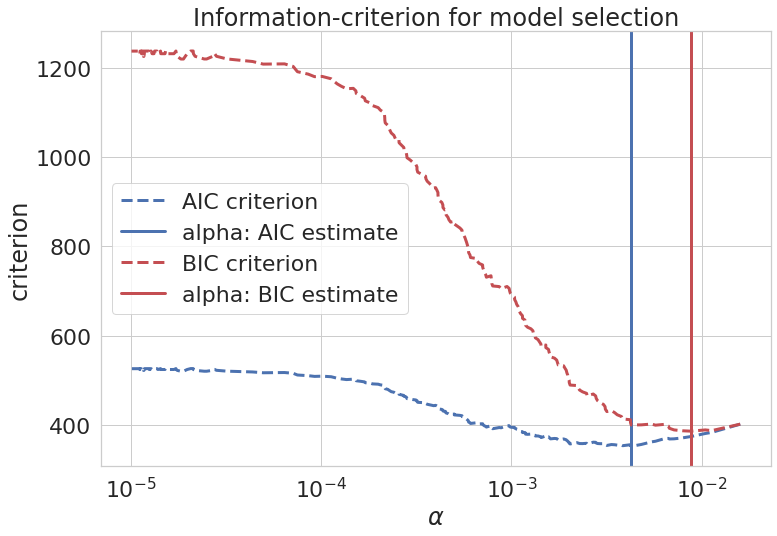

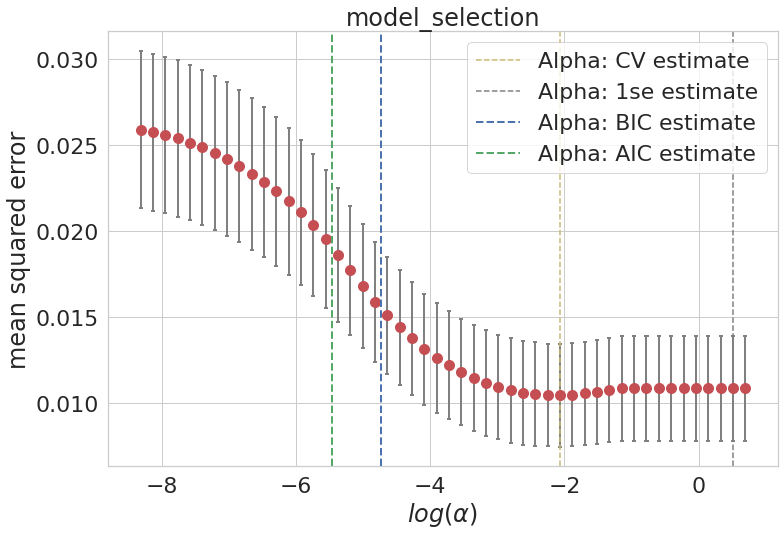

In [ ]:
ParSelect(df,10,2**(np.linspace(-12,1,50)))